In [1]:
import re
import math
from copy import deepcopy

class ts_sensor_data_t():
    def __init__(self, TS_SCAN_SIZE):
        self.TS_SCAN_SIZE = TS_SCAN_SIZE
        self.timestamp = 0
        self.q1 = 0
        self.q2 = 0
        self.scan = []

        for i in range(0, self.TS_SCAN_SIZE):
            elements = [0]*4
            self.scan.append(elements)

class ExtendedFunctions():
    def __init__(self):
        self.TEST_SCAN_SIZE = 682
        self.TEST_MIN_DIST  = 20
        self.TEST_ANGLE_MIN = -120
        self.TEST_ANGLE_MAX = +120
        self.TEST_OFFSET_LASER = 145
        self.TEST_HOLE_WIDTH = 600
        self.M_PI = 3.14159265358979323846

        self.TS_SCAN_SIZE = 683
        self.TS_MAP_SIZE = 360
        self.TS_MAP_SCALE = 0.017578125
        self.TS_DISTANCE_NO_DETECTION = 4000
        self.TS_NO_OBSTACLE = 65500
        self.TS_OBSTACLE = 0
        self.TS_HOLE_WIDTH = 600

        self.val = 1
        self.RAND_MAX = 0x7fff

    #Copy array from one to the other
    def passValues(self, iscan):
        oscan = iscan[:]
        return oscan


    #Read Data from data file
    def read_sensor_data(self, data):
        nb_sensor_data = 0
        d = [0] * self.TS_SCAN_SIZE
        num = 0

        # Read in data
        input = open('/home/xilinx/DataFiles/test_lab.dat', 'r')
        while True:
            rstr = input.readline()
            if not rstr:
                break

            str = re.split(" ", rstr)
            data[nb_sensor_data].timestamp = float(str[0])
            data[nb_sensor_data].q1 = float(str[1])
            data[nb_sensor_data].q2 = float(str[2])
            data[nb_sensor_data].q2 = -data[nb_sensor_data].q2

            for i in range(0, self.TEST_SCAN_SIZE):
                try:
                    if (str[i + 18]):
                        d[i] = int(str[i + 18])
                    else:
                        d[i] = 0
                except IndexError:
                    d[i] = 0

            scan = self.passValues(data[nb_sensor_data].scan)
            nb_points = 0
            SPAN = 1
            for i in range(0, self.TEST_SCAN_SIZE):
                for j in range(0, SPAN):
                    angle_deg = self.TEST_ANGLE_MIN + float((i * SPAN + j)) * (self.TEST_ANGLE_MAX - self.TEST_ANGLE_MIN) / (self.TEST_SCAN_SIZE * SPAN - 1)
                    angle_rad = angle_deg * self.M_PI / 180
                    if ((i > 45) and (i < self.TEST_SCAN_SIZE - 45)):
                        if (d[i] == 0):
                            scan[nb_points][1] = self.TS_DISTANCE_NO_DETECTION * math.cos(angle_rad)
                            scan[nb_points][2] = self.TS_DISTANCE_NO_DETECTION * math.sin(angle_rad)
                            scan[nb_points][3] = self.TS_NO_OBSTACLE
                            scan[nb_points][1] += self.TEST_OFFSET_LASER
                            nb_points += 1
                        if (d[i] > (self.TEST_HOLE_WIDTH / 2)):
                            scan[nb_points][1] = d[i] * math.cos(angle_rad)
                            scan[nb_points][2] = d[i] * math.sin(angle_rad)
                            scan[nb_points][3] = self.TS_OBSTACLE
                            scan[nb_points][1] += self.TEST_OFFSET_LASER
                            nb_points += 1

            for i in range(0, self.TS_SCAN_SIZE):
                scan[i][0] = nb_points

            data[nb_sensor_data].scan = self.passValues(scan)
            nb_sensor_data += 1
            num += 1

        input.close()
        return nb_sensor_data, data


    #Calculate New Map by updating data points
    def draw_scan(self, scan, dmap, dpos):
        c = math.cos(dpos[2] * self.M_PI / 180)
        s = math.sin(dpos[2] * self. M_PI / 180)
        x1 = math.floor(dpos[0] * self.TS_MAP_SCALE + 0.5)
        y1 = math.floor(dpos[1] * self.TS_MAP_SCALE + 0.5)

        for i in range(0, int(scan[0][0])):
            xs = scan[i][1]
            ys = scan[i][2]
            vs = scan[i][3]

            if (vs != self.TS_NO_OBSTACLE):
                x2p = c * xs - s * ys
                y2p = s * xs + c * ys
                x2p *= self.TS_MAP_SCALE
                y2p *= self.TS_MAP_SCALE
                x2 = int(math.floor(dpos[0] * self.TS_MAP_SCALE + x2p + 0.5))
                y2 = int(math.floor(dpos[1] * self.TS_MAP_SCALE + y2p + 0.5))
                if ((x2 >= 0) and (y2 >= 0) and (x2 < self.TS_MAP_SIZE) and (y2 < self.TS_MAP_SIZE)):
                    dmap[y2 * self.TS_MAP_SIZE + x2] = 0


    def record_map(self, imap, overlay, filename, width, height):
        output2 = open(filename, 'w')

        output2.write('P2\n%d %d 255\n' % (width, height))
        ry = (self.TS_MAP_SIZE - height) / 2

        for yp in range(0, height):
            rx = (self.TS_MAP_SIZE - width) / 2
            for xp in range(0, width):
                if (overlay[int((self.TS_MAP_SIZE - 1 - ry) * self.TS_MAP_SIZE + rx)] == 0):
                    output2.write('0 ')
                else:
                    output2.write("%d " % (int((imap[int((self.TS_MAP_SIZE - 1 - ry) * self.TS_MAP_SIZE + rx)]) >> 8)))

                rx += 1
            output2.write('\n')
            ry += 1

        output2.close()

In [2]:
from pynq import Xlnk
import numpy as np
import pynq.lib.dma
from pynq import Overlay
import random
import struct
import time

tinySLAM = Overlay('/home/xilinx/MyFiles/tinySLAM_Switch/V3/design_1.bit')
tiny_ip = tinySLAM.HLS_tinySLAM_0
dma_run = tinySLAM.dma_run
dma_pos = tinySLAM.dma_pos

TS_SCAN_SIZE = 683
TS_MAP_SIZE = 360
RAND_MAX = 0x7fff
TS_MAP_SCALE = 0.017578125

map_start = 0x40000
scan_start = 0x04000
in_value = 0x80000
out_value = 0x80008

class HLS_Functions():
    
    #//////////////////////////////////////////////////// Bit Converters //////////////////////////////////////
    def floatToBits(self, f):
        s = struct.pack('>f', f)
        return struct.unpack('>l', s)[0]

    def BitsTofloat(self, i):
        s = struct.pack('>l', i)
        return struct.unpack('>f', s)[0]
    
    #//////////////////////////////////////////////////// MAP INIT //////////////////////////////////////////
    def HLS_map_init(self):
        #Initialize Variables
        Run = xlnk.cma_array(shape=(1,), dtype=np.uint32)
        map1 = []
            
        #print("Activate Map Init...")
        Run[0] = 1
        dma_run.sendchannel.transfer(Run)
        dma_run.sendchannel.wait()
        
        #Delay to Allow time for calculation to complete
        time.sleep(0.1)
        
        #print("Reading Map...")
        for v in range(0, 64800):

            #Read in the 32 bit value
            location = map_start + 4*v
            val = tiny_ip.read(location)

            #Split into two 16 bit values
            upper = (val >> 16) & 0xFFFF
            lower = val & 0xFFFF

            #Append
            map1.append(lower)
            map1.append(upper)
            
        #print(map1)
        return map1
    
    #///////////////////////////////////////////////////// MAP UPDATE //////////////////////////////////////////
    def HLS_Main(self, scan, mp, pos):
        #Initialize Variables
        Run = xlnk.cma_array(shape=(1,), dtype=np.uint32)
        pos2 = xlnk.cma_array(shape=(3,), dtype=np.float32)
        map1 = []
        
        x = 0
        #print("Writing Scan...")
        for i in range(0, TS_SCAN_SIZE):
            for j in range(0, 4):
                location = scan_start + 4*x
                val = scan[i][j]
                var = self.floatToBits(val)
                tiny_ip.write(location,var)
                x += 1
        
        #print("Writing Map...")
        for v in range(0, 64800):
            #Combine two 16 bit values into a Single Value
            location = map_start + 4*v
            #val = (mp[2*v] << 16) | mp[(2*v)+1]
            val = (mp[(2*v)+1] << 16) | mp[2*v]

            #Write the 32 bit value
            tiny_ip.write(location,val)

        #print("Streaming Position")
        dma_pos.sendchannel.transfer(pos)
        dma_pos.sendchannel.wait()
        
        #print("Activate Main...")
        Run[0] = 2
        dma_run.sendchannel.transfer(Run)
        dma_run.sendchannel.wait()
        
        #Delay to Allow time for calculation to complete
        time.sleep(0.1)
        
        #print("Recieve New Position")
        dma_pos.recvchannel.transfer(pos2)
        dma_pos.recvchannel.wait()
        
        #print("Reading Map...")
        for v in range(0, 64800):

            #Read in the 32 bit value
            location = map_start + 4*v
            val = tiny_ip.read(location)

            #Split into two 16 bit values
            upper = (val >> 16) & 0xFFFF
            lower = val & 0xFFFF

            #Append
            map1.append(lower)
            map1.append(upper)
        
        return map1, pos2

Reading Sensor Data...
591
Map Init.....
#0 : 6144 6144 0


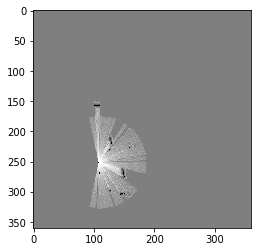

#1 : 6144 6144 0
#2 : 6145.6 6130.81 0.0144963
#3 : 6145.6 6130.81 0.0144963
#4 : 6145.6 6130.81 0.0144963
#5 : 6145.6 6130.81 0.0144963
#6 : 6143.79 6127.74 0.141911
#7 : 6143.79 6127.74 0.141911
#8 : 6143.79 6127.74 0.141911
#9 : 6143.79 6127.74 0.141911
#10 : 6143.79 6127.74 0.141911
#11 : 6143.79 6127.74 0.141911
#12 : 6136.38 6133.23 0.205237
#13 : 6137.84 6136.29 -0.0518815
#14 : 6129.34 6140.5 0.104526
#15 : 6121.96 6130.64 0.256355
#16 : 6121.96 6130.64 0.256355
#17 : 6121.96 6130.64 0.256355
#18 : 6121.48 6143.74 -0.0717185
#19 : 6124.49 6119.03 0.312815
#20 : 6124.49 6119.03 0.312815
#21 : 6124.49 6119.03 0.312815
#22 : 6126.15 6114 0.254067
#23 : 6126.15 6114 0.254067
#24 : 6115.35 6133.45 0.000762987
#25 : 6117.23 6130.92 0.0846889
#26 : 6111.8 6123.79 0.0991852
#27 : 6111.8 6123.79 0.0991852
#28 : 6111.8 6123.79 0.0991852
#29 : 6111.8 6123.79 0.0991852
#30 : 6114.23 6095.91 0.154118
#31 : 6114.23 6095.91 0.154118
#32 : 6103.84 6094.12 -0.0953703
#33 : 6103.84 6094.12 -0.09

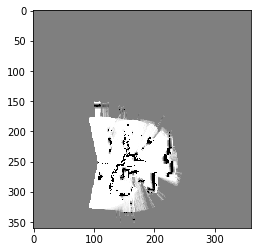

#101 : 9617.46 5885.74 21.2699
#102 : 9642.39 5901.05 20.9716
#103 : 9662.63 5897.42 20.9067
#104 : 9677.37 5895.47 21.3019
#105 : 9684.78 5894.4 21.1676
#106 : 9684.78 5894.4 21.1676
#107 : 9690.78 5885.87 21.3195
#108 : 9690.78 5885.87 21.3195
#109 : 9695.81 5874.99 21.4743
#110 : 9699.83 5897.59 20.7533
#111 : 9730.8 5910 20.6221
#112 : 9755.36 5906.13 20.703
#113 : 9777.83 5931.4 20.558
#114 : 9813.01 5947.43 20.4863
#115 : 9854.58 5949.66 20.5046
#116 : 9915.77 5981.37 19.9034
#117 : 10001.8 6015.18 19.1389
#118 : 10096.7 6050.62 18.3737
#119 : 10210.3 6092.71 18.038
#120 : 10337.9 6137.38 17.3994
#121 : 10471.8 6163.25 16.9904
#122 : 10624.8 6204.1 16.9965
#123 : 10750.8 6253.38 16.9973
#124 : 10884.5 6271.04 17.0949
#125 : 11044.5 6298.13 20.4123
#126 : 11182.9 6389.42 23.4352
#127 : 11338 6449.85 28.1159
#128 : 11456.2 6521.3 33.5795
#129 : 11565 6588.01 40.1517
#130 : 11651.6 6643.25 45.5016
#131 : 11716.7 6659.72 50.3883
#132 : 11746.8 6689.34 53.3997
#133 : 11783.5 6722.89 5

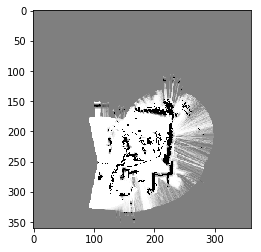

#201 : 12587.7 8574.92 73.8037
#202 : 12587.7 8574.92 73.8037
#203 : 12583.1 8569.78 73.8922
#204 : 12584.1 8576.51 73.8761
#205 : 12593 8582.39 74.9306
#206 : 12606.1 8596.14 77.5155
#207 : 12597.7 8563.55 80.6238
#208 : 12621 8581.13 87.3417
#209 : 12641 8557.86 94.2808
#210 : 12642.4 8657.9 105.562
#211 : 12608.5 8719.44 114.935
#212 : 12616.3 8776.36 123.057
#213 : 12603.5 8801.14 126.55
#214 : 12603.7 8818.46 127.13
#215 : 12596.1 8824.45 126.313
#216 : 12596.1 8824.45 126.313
#217 : 12596.1 8824.45 126.313
#218 : 12586.9 8835.83 125.291
#219 : 12621.7 8827.2 122.826
#220 : 12512.1 8953.07 123.557
#221 : 12456 9049.99 121.99
#222 : 12414.2 9142.16 120.283
#223 : 12389.5 9214.35 119.547
#224 : 12376.6 9248.48 119.285
#225 : 12363.9 9252.43 118.496
#226 : 12375.6 9243.67 118.831
#227 : 12375.6 9243.67 118.831
#228 : 12389.5 9234.12 118.476
#229 : 12413.3 9242.65 118.634
#230 : 12420.3 9239.77 119.179
#231 : 12422.8 9261.17 122.119
#232 : 12430.2 9283.44 125.784
#233 : 12415.4 9305.0

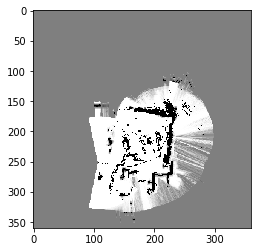

#301 : 12244.9 9459.23 172.3
#302 : 12227.9 9460.63 172.373
#303 : 12191 9471.65 172.893
#304 : 12139.7 9481.63 174.22
#305 : 12084.3 9490.08 175.304
#306 : 12032.5 9491.75 175.973
#307 : 11983.4 9507.2 177.331
#308 : 11942.6 9505.54 177.936
#309 : 11921.1 9506.53 178.666
#310 : 11887.5 9513.16 179.451
#311 : 11862.6 9504.65 179.941
#312 : 11841 9504.6 181.001
#313 : 11821 9510.29 181.159
#314 : 11801.6 9505.14 181.642
#315 : 11801.6 9506.28 181.394
#316 : 11801.6 9506.28 181.394
#317 : 11800.2 9497.62 181.38
#318 : 11801.7 9490.32 181.057
#319 : 11784.9 9503.73 181.17
#320 : 11742.9 9478.65 180.317
#321 : 11695.6 9485.11 180.152
#322 : 11628 9488.13 180.29
#323 : 11541.6 9490.91 180.617
#324 : 11387 9502.11 180.881
#325 : 11334.1 9538.83 182.836
#326 : 11227.1 9531.87 182.936
#327 : 11126.5 9538.85 183.432
#328 : 11061.3 9538.94 183.029
#329 : 10993.1 9524.04 181.378
#330 : 10922.6 9519.42 175.105
#331 : 10866.7 9534.35 164.323
#332 : 10771 9550.38 148.041
#333 : 10732.2 9592.46 132.9

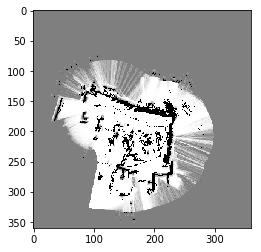

#401 : 6723.31 11385.3 201.265
#402 : 6714.81 11365.1 201.902
#403 : 6675.11 11369.3 203.288
#404 : 6608.6 11327.3 203.469
#405 : 6526.95 11300.5 203.668
#406 : 6465.49 11276.7 206.098
#407 : 6413.89 11252.8 209.488
#408 : 6341.83 11194 214.292
#409 : 6248.01 11140 219.424
#410 : 6169.22 11078.2 222.09
#411 : 6131.71 11048.9 222.515
#412 : 6104.02 11027.5 222.845
#413 : 6079.89 11013.1 223.434
#414 : 6067.62 11005.6 223.313
#415 : 6057.96 10999.6 223.258
#416 : 6065.24 11003.5 223.533
#417 : 6065.24 11003.5 223.533
#418 : 6065.24 11003.5 223.533
#419 : 6074.07 11001.6 223.861
#420 : 6075.71 11016 224.196
#421 : 6075.71 11016 224.196
#422 : 6051.84 11003.5 222.2
#423 : 5987.85 10972.5 215.381
#424 : 5944.57 10939.1 204.056
#425 : 5875.13 10908.8 190.204
#426 : 5835.03 10927 180.735
#427 : 5788.27 10963.7 178.235
#428 : 5767.52 10988.1 176.381
#429 : 5746.86 10990.8 176.566
#430 : 5762.34 10981.1 175.837
#431 : 5773.79 10987.3 174.962
#432 : 5777.25 10997.6 175.793
#433 : 5777.25 10997.6

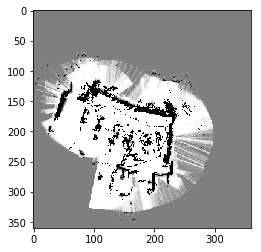

#501 : 4771.81 11548.7 211.354
#502 : 4738.54 11538.8 212.266
#503 : 4728.2 11531 212.717
#504 : 4721.23 11535.6 213.469
#505 : 4721.23 11535.6 213.469
#506 : 4720.25 11550.3 213.73
#507 : 4720.25 11550.3 213.73
#508 : 4724.49 11545.6 213.582
#509 : 4720.54 11563.3 213.821
#510 : 4720.54 11563.3 213.821
#511 : 4720.54 11563.3 213.821
#512 : 4704.49 11551.3 213.993
#513 : 4681.78 11534.4 214.889
#514 : 4649.36 11508 216.156
#515 : 4633.08 11506.9 216.895
#516 : 4618.22 11496.3 217.483
#517 : 4603.72 11492.9 218.642
#518 : 4603.72 11492.9 218.642
#519 : 4592.6 11496.6 218.973
#520 : 4569.35 11477.8 220.434
#521 : 4530.27 11441.7 221.558
#522 : 4488.72 11416 223.502
#523 : 4434.28 11361.8 226.389
#524 : 4389.22 11325.8 228.838
#525 : 4366.25 11304 229.93
#526 : 4345.74 11282.4 231.117
#527 : 4323.33 11281.6 232.132
#528 : 4315.97 11271.2 232.603
#529 : 4315.97 11271.2 232.603
#530 : 4303.43 11253.1 233.718
#531 : 4298.75 11236 235.493
#532 : 4279.18 11218.1 237.332
#533 : 4255.25 11174.3 

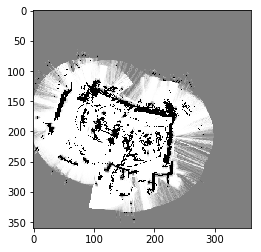

Finished!!
Time: 0:55:21.783728


In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
import cv2
from pynq import Xlnk
import numpy as np
import pynq.lib.dma
from pynq import Overlay
import random
import datetime

################################################## MAIN ################################################################
#//Initialise Variables
time_start = datetime.datetime.now()
xlnk = Xlnk()
functions = ExtendedFunctions()
hls_func = HLS_Functions()
Sensor_Data = []
told = 0
filename = ""

#Initialize Arrays
scaner = []
pos = xlnk.cma_array(shape=(3,), dtype=np.float32)

for i in range(0, 600):
    Sensor_Data.append(ts_sensor_data_t(functions.TS_SCAN_SIZE))
        
for i in range(0, functions.TS_SCAN_SIZE):
    elements = [0]*4
    scaner.append(elements)

#// Read all the scans
print("Reading Sensor Data...");
nb_sens_dat, Sensor_Data = functions.read_sensor_data(Sensor_Data)
print(nb_sens_dat)

#////////////////////////////////////Initial machine pose//////////////////////////////////////
pos[0] = (functions.TS_MAP_SIZE / functions.TS_MAP_SCALE)*0.3
pos[1] = (functions.TS_MAP_SIZE / functions.TS_MAP_SCALE)*0.3
pos[2] = 0.0

print("Map Init.....")
mp = hls_func.HLS_map_init()
traj = hls_func.HLS_map_init()

output = open("test_trajectory.dat", 'w')

for cnt_scans in range(0, nb_sens_dat):
    for i in range(0, functions.TS_SCAN_SIZE):
        scaner[i][0] = Sensor_Data[cnt_scans].scan[i][0]
        scaner[i][1] = Sensor_Data[cnt_scans].scan[i][1]
        scaner[i][2] = Sensor_Data[cnt_scans].scan[i][2]
        scaner[i][3] = Sensor_Data[cnt_scans].scan[i][3]
        
    timestamp = Sensor_Data[cnt_scans].timestamp

    #/////////////////////////// HLS Functions ///////////////////////////////
    mp, pos2 = hls_func.HLS_Main(scaner, mp, pos)
    
    for i in range(0, 3):
        pos[i] = pos2[i]

    print("#%d : %lg %lg %lg" % (cnt_scans, pos[0], pos[1], pos[2]))

    #///////////////////////////Set Current Pose as Obstacle Point//////////////////////////
    x = (int(math.floor(pos[0] * functions.TS_MAP_SCALE + 0.5)))
    y = (int(math.floor(pos[1] * functions.TS_MAP_SCALE + 0.5)))

    if ((x >= 0) and (y >= 0) and (x < functions.TS_MAP_SIZE) and (y < functions.TS_MAP_SIZE)):
        traj[y * functions.TS_MAP_SIZE + x] = 0

    #///////////////////////////Update the obstacle point map///////////////////////////////
    functions.draw_scan(scaner, traj, pos)
    
    if(cnt_scans % 100 == 0):
        filename = "/home/xilinx/DataFiles/test_lab_reversed2.pgm"
        functions.record_map(mp, traj, filename, functions.TS_MAP_SIZE, functions.TS_MAP_SIZE)
        
        image = cv2.imread(filename)
        plt.imshow(image)
        plt.show()

    #//Set values equal to current for next loop.
    told = timestamp
    output.write("\n")

output.close()

#// Record the map
print("Converting to PGM")
filename = "/home/xilinx/DataFiles/test_lab_reversed2.pgm"
functions.record_map(mp, traj, filename, functions.TS_MAP_SIZE, functions.TS_MAP_SIZE)

image = cv2.imread(filename)
plt.imshow(image)
plt.show()

print("Finished!!")
time_end = datetime.datetime.now()
delta = time_end - time_start

print("Time:", delta)